In [0]:
#!pip3 install torch torchvision

In [0]:
#!pip3 install fastai==0.7.0

In [0]:
#!pip3 install torchtext==0.2.3

In [0]:
#from google.colab import drive

#drive.mount('/content/gdrive')

In [0]:
from fastai.text import * 

DATA_PATH = '/content/gdrive/My Drive/CS/SI/Proyecto/database/'

In [0]:
train_ids = np.load(DATA_PATH + 'ulmfit/tmp/train_lm.npy')
test_ids  = np.load(DATA_PATH + 'ulmfit/tmp/test_lm.npy')
itos      = pickle.load(open(DATA_PATH + 'ulmfit/tmp/itos.pkl', 'rb'))

In [86]:
vs=len(itos)
vs,len(train_ids)

(1243, 736)

## Wikitext103

We use a transfer learning method to learn the structure of the spanish language. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(like wikipedia articles) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. Link to dataset The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: Link. Our target LM is the IMDB LM.

In [0]:
WIKITEX = DATA_PATH + 'ulmfit/'

In [0]:
#!wget -nH -r -np -P ../database/ulmfit/model/ http://files.fast.ai/models/wt103/fwd_wt103.h5

In [0]:
#!wget -nH -r -np -P ../database/ulmfit/model/ http://files.fast.ai/models/wt103/itos_wt103.pkl

In [0]:
em_sz, nh, nl = 400, 1150, 3

In [0]:
PRE_PATH    = WIKITEX  + 'models/wt103/'
PRE_LM_PATH = PRE_PATH + 'fwd_wt103.h5'

In [0]:
wgts = torch.load(str(PRE_LM_PATH), map_location=lambda storage, loc: storage)

In [0]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m    = enc_wgts.mean(0)

In [0]:
itos2 = pickle.load(open(PRE_PATH + 'itos_wt103.pkl','rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [0]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)

c1 = 0
c2 = 0
for i,w in enumerate(itos):
    r = stoi2[w]
    
    if r >= 0:
      new_w[i] = enc_wgts[r]
      c1+=1
    else:
      new_w[i] = row_m
      c2+=1

In [91]:
print('Número de palabras encontradas en el encoder    : ', c1)
print('Número de palabras no encontradas en el encoder : ', c2)

Número de palabras encontradas en el encoder    :  684
Número de palabras no encontradas en el encoder :  559


In [0]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Training A new IMDB language model

In [0]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [0]:
ULMFIT_PATH = DATA_PATH + 'ulmfit/'
TASS_PATH   = DATA_PATH + '/tass_model/'

In [0]:
trn_dl = LanguageModelLoader(np.concatenate(train_ids), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(test_ids), bs//4, bptt)
md     = LanguageModelData(TASS_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [0]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [0]:
learner= md.get_model(opt_fn, em_sz, nh, nl, dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [0]:
learner.model.load_state_dict(wgts)

In [0]:
lr  = 1e-2
lrs = lr

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [293]:
learner.fit(lrs, 1 , wds=wd, use_clr=(32,2), cycle_len=10)

epoch      trn_loss   val_loss   accuracy   
    0      6.273668   6.228341   0.038562  
    1      6.242661   5.984564   0.049896  
    2      6.095892   5.716833   0.061627  
    3      5.939519   5.506276   0.086764  
    4      5.789856   5.445972   0.138161  
    5      5.654947   5.481289   0.157729  
    6      5.532014   5.467879   0.16426   
    7      5.423908   5.448707   0.163462  
    8      5.33299    5.446151   0.162824  
    9      5.256924   5.448186   0.162073  


[array([5.44819]), 0.16207322147600153]

In [0]:
learner.save(TASS_PATH + 'lm_last_ft')

In [0]:
learner.load(TASS_PATH + 'lm_last_ft')

In [0]:
learner.unfreeze()

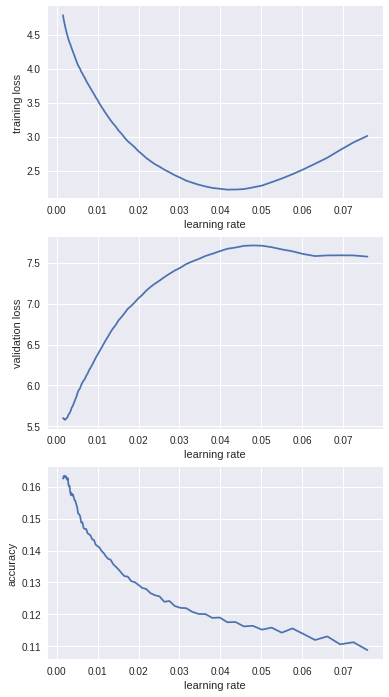

In [298]:
learner.lr_find2(start_lr=lrs/10, end_lr=lrs*10, num_it=100)
learner.sched.plot()

In [301]:
learner.fit(lrs/10, 1, wds=wd, use_clr=(20,10), cycle_len=30, best_save_name=TASS_PATH + 'lm1')

epoch      trn_loss   val_loss   accuracy   
    0      2.407868   7.232825   0.117176  
    1      2.440147   7.263969   0.121881  
    2      2.385576   7.422978   0.127314  
    3      2.36582    7.483007   0.122667  
    4      2.342885   7.456886   0.115594  
    5      2.314352   7.454492   0.117323  
    6      2.268978   7.538301   0.123591  
    7      2.249991   7.713232   0.115735  
    8      2.213528   7.733872   0.116333  
    9      2.218122   7.704105   0.115174  
    10     2.180464   7.689431   0.114339  
    11     2.144478   7.780492   0.115488  
    12     2.115052   7.875275   0.118918  
    13     2.085679   7.951004   0.114436  
    14     2.055984   7.910011   0.111979  
    15     2.028096   7.929762   0.110403  
    16     2.005655   7.998807   0.111486  
    17     1.977586   8.010865   0.111814  
    18     1.952104   8.095935   0.108648  
    19     1.934271   8.085641   0.110679  
    20     1.911298   8.108245   0.114583  
    21     1.89256    8.190028 

[array([8.19687]), 0.10957532094713922]

In [0]:
#learner.save(TASS_PATH+'lm1')
#learner.save_encoder(TASS_PATH+'lm1_enc')

learner.load(TASS_PATH +'lm1')
learner.save_encoder(TASS_PATH +'lm1_enc')

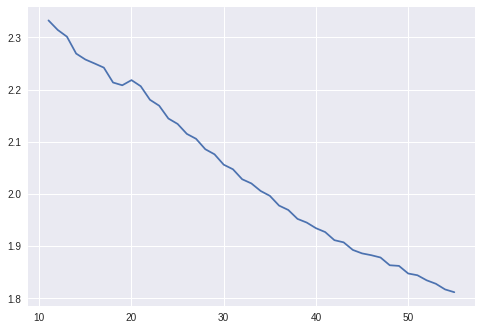

In [303]:
learner.sched.plot_loss()

## Clasifier

In [0]:
train_labels = np.squeeze(np.load(DATA_PATH + 'ulmfit/tmp/train_labels.npy'))
test_labels  = np.squeeze(np.load(DATA_PATH + 'ulmfit/tmp/test_labels.npy'))

In [0]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [306]:
min_lbl = train_labels.min()
print(min_lbl)
c=int(train_labels.max())+1
print(c == 2)

0
True


In [307]:
len(train_ids), len(train_labels), len(test_ids), len(test_labels)

(736, 736, 375, 375)

In [0]:
trn_ds   = TextDataset(train_ids, train_labels)
val_ds   = TextDataset(test_ids, test_labels)

trn_samp = SortishSampler(train_ids, key=lambda x: len(train_ids[x]), bs=bs//2)
val_samp = SortSampler(test_ids, key=lambda x: len(test_ids[x]))

trn_dl   = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl   = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)

md       = ModelData(ULMFIT_PATH, trn_dl, trn_dl)

In [0]:
dps = np.array([0.4,0.5,0.05,0.3,0.1])

In [0]:
def get_rnn_classifier(bptt, max_seq, n_class, n_tok, emb_sz, n_hid, n_layers, pad_token, layers, drops, bidir=False,
                       dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5):
  
  rnn_enc = MultiBatchRNN(bptt, max_seq, n_tok, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                          dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
  
  return SequentialRNN(rnn_enc, PoolingLinearClassifier(layers, drops))

In [0]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [0]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [0]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip= .25
learn.metrics = [accuracy]

In [0]:
lr  = 1e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [0]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [0]:
wd = 1e-3
learn.load_encoder(TASS_PATH + 'lm1_enc')

In [0]:
learn.freeze_to(-1)

In [318]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      0.703263   0.698546   0.531017  


[array([0.69855]), 0.5310167919899991]

In [0]:
learn.save(TASS_PATH + 'clas2_0')

In [0]:
learn.load(TASS_PATH + 'clas2_0')

In [0]:
learn.freeze_to(-2)

In [322]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      0.663262   0.675816   0.571742  


[array([0.67582]), 0.5717418527132586]

In [0]:
learn.save(TASS_PATH + 'clas2_1')

In [0]:
learn.load(TASS_PATH + 'clas2_1')

In [0]:
learn.unfreeze()

In [326]:
learn.fit(lrs, 1, wds=wd, cycle_len=30, use_clr=(32,10), best_save_name=TASS_PATH + 'clas2')

epoch      trn_loss   val_loss   accuracy   
    0      0.663653   0.64159    0.607353  
    1      0.658571   0.654972   0.618451  
    2      0.671852   0.647021   0.664052  
    3      0.672044   0.639192   0.611264  
    4      0.665099   0.66602    0.601743  
    5      0.6715     0.618399   0.666443  
    6      0.657344   0.603699   0.681763  
    7      0.646846   0.602369   0.683556  
    8      0.645797   0.594193   0.697575  
    9      0.649526   0.580844   0.708643  
    10     0.649042   0.576127   0.730101  
    11     0.642764   0.549882   0.740568  
    12     0.644475   0.566977   0.757417  
    13     0.629389   0.527899   0.766922  
    14     0.631358   0.548857   0.739602  
    15     0.625258   0.534043   0.773655  
    16     0.609334   0.530474   0.742601  
    17     0.601966   0.52727    0.738847  
    18     0.589009   0.478197   0.788392  
    19     0.597475   0.543863   0.733252  
    20     0.593334   0.513201   0.771469  
    21     0.59535    0.526002 

[array([0.45406]), 0.8042550065913385]

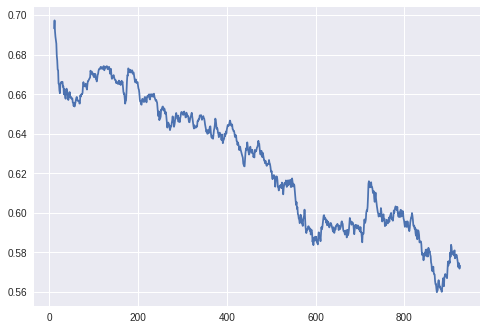

In [327]:
learn.sched.plot_loss()

In [0]:
learn2 = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn2.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn2.clip=.12
learn2.metrics = [accuracy]

learn2.load(TASS_PATH + 'clas2')
mev = learn2.model
mev[0].bs=1

In [330]:
c = 0

train_ids_f = np.copy(train_ids)

for i in range(len(train_ids_f)):
  mev.eval()
  mev.reset()
  input_seq = np.array(train_ids_f[i]).reshape(-1,1)
  p = mev(VV(input_seq))
 
  if (to_np(torch.topk(p[0],1)[1])[0][0] == train_labels[i]):
    c+=1

print('Train Accuracy = ', 100*c / len(train_ids_f))

Train Accuracy =  82.7445652173913


In [331]:
c = 0

test_ids_f = np.copy(test_ids)

for i in range(len(test_ids_f)):
  mev.eval()
  mev.reset()
  input_seq = np.array(test_ids_f[i]).reshape(-1,1)
  p = mev(VV(input_seq))
 
  if (to_np(torch.topk(p[0],1)[1])[0][0] == test_labels[i]):
    c+=1

print('Test Accuracy = ', 100*c / len(test_ids_f))

Test Accuracy =  62.4
